# About this Notebook:

A bidirectional GRU with attention model as baseline to test feasibility of question answering. The model architecture is adopted from a simplified version of BiDAF model and a medium article. 




Architecture summary:
We adopted a bidirectional GRU and attention architecture to test the feasibility of our transfer learning approach. The model is composed of a word embedding layer, which maps each word in context and question to a vector space using a pretrained GloVe word embedding model. Both question and context have a bidirectional GRU layer to learn the contextual cues from surrounding words to refine the embedding of the words. The outputs were fed into an attention flow layer, which couples the question and context to produce a set of query-aware feature vectors for each word. The model outputs are start position, end position and probability of having answers, each was obtained by applying softmax on attention output. The model label is  one-hot encoded spans where all positions within answers are labeled as one.


Reference: 	
1. https://arxiv.org/abs/1611.01603 arXiv:1611.01603 
2. https://medium.com/@kunalmishra78/building-a-context-based-question-answering-system-on-squad-2-0-cc33aeb61d13


In [ ]:
! pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 365 kB 7.9 MB/s 
     |████████████████████████████████| 212 kB 42.7 MB/s 
     |████████████████████████████████| 101 kB 7.7 MB/s 
     |████████████████████████████████| 141 kB 43.3 MB/s 
     |████████████████████████████████| 596 kB 34.8 MB/s 
     |████████████████████████████████| 127 kB 40.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 whi

In [ ]:
#importing all the libraries
import requests
import os
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datasets import load_dataset, load_metric
warnings.filterwarnings("ignore")
import pandas as pd
import re
import pickle

import numpy as np
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Dense, Input, Lambda, GRU, Bidirectional, Flatten
from tensorflow.keras.backend import softmax, concatenate, int_shape, reshape, batch_dot
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
import numpy as np



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls drive/MyDrive/w266/GRU/Model_newloss/

gru_pred_results.json  test_data.pkl   weights.01-121.5280.hdf5
preprocessing.pkl      train_data.pkl  weights.01-4079.7476.hdf5


In [ ]:
# path to train and test dataset
import json
train = load_dataset('json', data_files = 'drive/MyDrive/w266/data/natural_questions/train_set.json')
train = train['train']
test = load_dataset('json', data_files = 'drive/MyDrive/w266/data/natural_questions/test_set.json')
test = test['train']

Using custom data configuration default-80ce7cce09f97876


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-80ce7cce09f97876/0.0.0/a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-e8e96da598a344c4


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-e8e96da598a344c4/0.0.0/a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

#### Export formatted dataset in pickle

In [ ]:
def format(data):
  if len(data['answers']['text'])!=0:
    data['answer'] = data['answers']['text'][0]
    answer_len = len(data['answers']['text'][0])
    data['start_index'] = data['answers']['answer_start'][0]
    data['end_idx'] = data['start_index'] + answer_len
    data['is_imp'] = [1,0] 
  else:
    data['answer']= ''
    data['start_index'] = -1
    data['end_idx'] = -1
    data['is_imp'] = [0,1]
  return data


In [ ]:
!ls drive/MyDrive/w266/GRU/

Model_10E  Model_newloss


In [ ]:
train_rfm = train.map(format, remove_columns=['answers', 'id'])
test_rfm = test.map(format, remove_columns = ['answers'])

df_train=pd.DataFrame(train_rfm, columns=['context','question','answer','start_index','end_idx','is_imp'])
df_train.to_pickle('drive/MyDrive/w266/GRU/Model_newloss/train_data.pkl')

df_test=pd.DataFrame(test_rfm,columns=['context','question','answer','start_index','end_idx','is_imp','id'])
df_test.to_pickle('drive/MyDrive/w266/GRU/Model_newloss/test_data.pkl')

### hyper parameters

In [ ]:
CONTEXT_LEN = 300
QUESTION_LEN = 30
EMBEDDING_SIZE = 100
VOCAB_SIZE = 475514
HIDDEN_GRU_UNITS = 100

### Finding number of unique words in context

In [ ]:
# uq = set()
# for i in range(len(train_data)):
#   sample = train_data.iloc[i]
#   tokens = sample[0].split(' ')
#   uq.update(tokens)
# len(uq)

### Tokenization

In [ ]:
#vectorizing the dataset

class Vectorizations:

    def __init__(self, size):
        self.tokenizer = Tokenizer(oov_token='<UNK>', lower=True, char_level=False)
        self.vocab_size = 0
        self.num_words = size

    def create_vocabulary(self, texts):
        self.tokenizer.fit_on_texts(texts)
        self.tokenizer.word_index = {e: i for e, i in self.tokenizer.word_index.items() if i <= self.num_words}
        self.tokenizer.index_word = {i: e for e, i in self.tokenizer.word_index.items() if i <= self.num_words}
        self.tokenizer.word_index[self.tokenizer.oov_token] = len(self.tokenizer.word_index) + 1
        self.vocab_size = self.num_words + 1
    

    def text_to_seq(self, text, maxlen):
        seq = []
        words = text_to_word_sequence(text,
                          filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n',
                          lower=True,
                          split=' ')
        for word in words:
            if self.tokenizer.word_index.get(word):
                seq.append(self.tokenizer.word_index[word])
            else:
                seq.append(self.tokenizer.word_index['<UNK>'])
        seq = pad_sequences([seq], maxlen=maxlen, truncating='post', padding='post')
        return seq

    def sequence_to_text(self, sequence):
        text = ''
        for s in sequence:
            if self.tokenizer.index_word.get(s):
                text = text + ' ' + self.tokenizer.index_word[s]
        return text.strip()
    
    def text_to_seq_sample(self, sample, seq_len=(CONTEXT_LEN, QUESTION_LEN)):
        sequence = list()
        sequence.append(self.text_to_seq(sample[0], seq_len[0]))
        sequence.append(self.text_to_seq(sample[1], seq_len[1]))
        target_start = np.zeros(shape=(CONTEXT_LEN,))
        target_end = np.zeros(shape=(CONTEXT_LEN,))
        sequence.append(sample[2])  # save for postprocessing
        start = [ele.start() for ele in re.finditer(r'\S+', sample[0])]  # got map of char indexes
        end =  [ele.end() for ele in re.finditer(r'\S+', sample[0])]
        if sample[3] != -1 and sample[4] != -1:
          start_token = start.index(sample[3])
          end_token = end.index(sample[4])
          if end_token < CONTEXT_LEN:
            target_start[start_token:end_token] = 1  
            target_end[start_token:end_token] = 1
        sequence.append(target_start)
        sequence.append(target_end)
        sequence.append(np.array(sample[5]))
        if len(sample) == 7:
            sequence.append(sample[-1])
        return sequence

    def sequence_to_text(self, sequence):
        text = ''
        for s in sequence:
            if self.tokenizer.index_word.get(s):
                text = text + ' ' + self.tokenizer.index_word[s]
        return text.strip()

    def target_to_words(self, context, start, end, is_no_ans):
        if is_no_ans.argmax() == 1:
            return ''
        if start < end + 1:
            return self.sequence_to_text(context[start:end + 1])
        else:
            return ''


### Baseline Model： BiGRU with Attention

Inputs take in context and questions per sample and three outputs varaible, probability of being start/end poisition of answer span for each token index. 

In [ ]:
# def total_loss(y_true, y_pred):
#   start_positions, end_positions = y_true[0], y_true[1]
#   start_logits, end_logits = y_pred[:,:,0], y_pred[:,:,1]

#   sum_start = tf.math.reduce_sum(start_positions * tf.math.log(start_logits)) #shape=(5, 100)
#   sum_end = tf.math.reduce_sum(end_positions * tf.math.log(end_logits))
#   # sum_ans = tf.math.reduce_sum(answer_prob * tf.math.log(answer_prob))

#   total_loss = - tf.math.reduce_mean([sum_start, sum_end])

#   return total_loss

In [ ]:
def build_model(tokenizer,matrix):
    embedding_weights = matrix

    # Model layers
    question = Input(shape=(QUESTION_LEN,), name='question_input')
    context = Input(shape=(CONTEXT_LEN,), name='context_input')
    embedding = Embedding(len(tokenizer.word_index) + 2, EMBEDDING_SIZE, weights=[embedding_weights],
                          trainable=False)
    question_encoder = Bidirectional(
        GRU(HIDDEN_GRU_UNITS, input_shape=(QUESTION_LEN, EMBEDDING_SIZE), return_sequences=True,
            recurrent_dropout=0.2), name='Question_encoder')
    context_encoder = Bidirectional(
        GRU(HIDDEN_GRU_UNITS, input_shape=(CONTEXT_LEN, EMBEDDING_SIZE), return_sequences=True,
            recurrent_dropout=0.4), name='Context_encoder')
    attention = Lambda(lambda x: softmax(x), name='softmax')
    attention_in = Lambda(lambda x: batch_dot(x[0], x[1]), name='dotProduct_in')
    attention_matrix = Lambda(lambda x: batch_dot(x[0], x[1]), name='dotProduct_mat')
    concat_layers = Lambda(lambda x: concatenate([x[0], x[1]], axis=-1), name='concat')
    flatten = Flatten()
    output_start = Dense(CONTEXT_LEN, activation='softmax', kernel_regularizer=regularizers.l2(0.01),
                         bias_regularizer=regularizers.l2(0.01), name='p_start')
    output_end = Dense(CONTEXT_LEN, activation='softmax', kernel_regularizer=regularizers.l2(0.01),
                       bias_regularizer=regularizers.l2(0.01), name='p_end')

    # Since using sigmoid and binary_crossentropy along with categorical will require a custom loss function,
    # I've converted the output to a categorical variable([0, 1] for no ans, [1, 0] otherwise), and used one
    # loss function for the entire model
    output_no_answer = Dense(2, activation='softmax', name='no_answer')

    # Model architecture
    question_embedding = embedding(question)
    context_embedding = embedding(context)
    question_encoder_output = question_encoder(question_embedding)
    context_encoder_output = context_encoder(context_embedding)

    # To take a transpose of context_encoder_output, while keeping the batch dimension fixed
    batch_size, dim1, dim2 = int_shape(question_encoder_output)
    in_shape = (dim2, dim1)
    in_shape = (-1,) + in_shape

    question_encoder_out = Lambda(lambda x: reshape(x, in_shape))(question_encoder_output)
    attention_in = attention_in([context_encoder_output, question_encoder_out])
    attention_out = attention(attention_in)
    attention_matrix = attention_matrix([attention_out, question_encoder_output])
    concatenated = concat_layers([context_encoder_output, attention_matrix])
    concatenated = flatten(concatenated)

    out_start = output_start(concatenated)
    out_noans = output_no_answer(concatenated)
    out_end = output_end(concatenated)

    model = Model(inputs=[question, context], outputs=[out_start, out_end, out_noans])
    model.summary()
    model.compile(optimizer=Adam(0.00002), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['acc'])
    return model


def load_pretrained_embedding(glove_dir, embedding_dim, tokenizer):
    embeddings_index = {}
    with open(os.path.join(glove_dir, 'glove.6B.100d.txt'.format(embedding_dim)), 'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print('Found %s word vectors.' % len(embeddings_index))
    embedding_matrix = np.zeros([len(tokenizer.word_index) + 2, embedding_dim], dtype="float32")
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix



glove word embedding weights: 400000 words

In [ ]:
# path = os.path.join('drive/MyDrive/w266/', 'glove.6B.100d.txt')
# path
embeddings_index = {}
with open(os.path.join('drive/MyDrive/w266/', 'glove.6B.100d.txt'.format(100)), 'r') as f:
  for line in f:
      values = line.split()
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [25]:
preprocessing = Vectorizations(size=VOCAB_SIZE)

# Loading the train data
with open('drive/MyDrive/w266/GRU/Model_newloss/train_data.pkl', 'rb') as f:
    train_data = pickle.load(f)

texts = []

for i in range(len(train_data)):
  sample = train_data.iloc[i]
  text = sample[:3]

for i in range(len(train_data)):

  sample = train_data.iloc[i]
  context = sample[0]
  question = sample[1]
  answer = sample[2]

  texts.append(context)
  texts.append(question)
  texts.append(answer)

preprocessing.create_vocabulary(texts)
print('Vocabulary size: {}'.format(preprocessing.vocab_size))

preprocessed_train_data = list()
# for sample in df_f:
for i in range(len(train_data)):
  sample = train_data.iloc[i]
  if sample[4] < CONTEXT_LEN:  # answer is in context 325 words, Only considering contexts smaller than 325 words
      preprocessed_train_data.append(preprocessing.text_to_seq_sample(sample))

with open('drive/MyDrive/w266/GRU/Model_newloss/preprocessing.pkl', 'wb') as f:
    pickle.dump(preprocessing, f)
tokenizer=preprocessing.tokenizer
print('Done with processing..')

KeyboardInterrupt: ignored

In [ ]:
# preprocessed_train_data[1]

In [ ]:
import tensorflow as tf

In [ ]:
embedding_weights = load_pretrained_embedding(glove_dir = 'drive/MyDrive/w266/', embedding_dim=EMBEDDING_SIZE, tokenizer=tokenizer)
model = build_model(tokenizer,embedding_weights)

Found 400000 word vectors.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 context_input (InputLayer)     [(None, 300)]        0           []                               
                                                                                                  
 question_input (InputLayer)    [(None, 30)]         0           []                               
                                                                                                  
 embedding (Embedding)          multiple             200         ['question_input[0][0]',         
                                                                  'context_input[0][0]']          
                                                                                                  
 Question_encoder (Bidirectiona  (None, 30, 200)     121200      ['

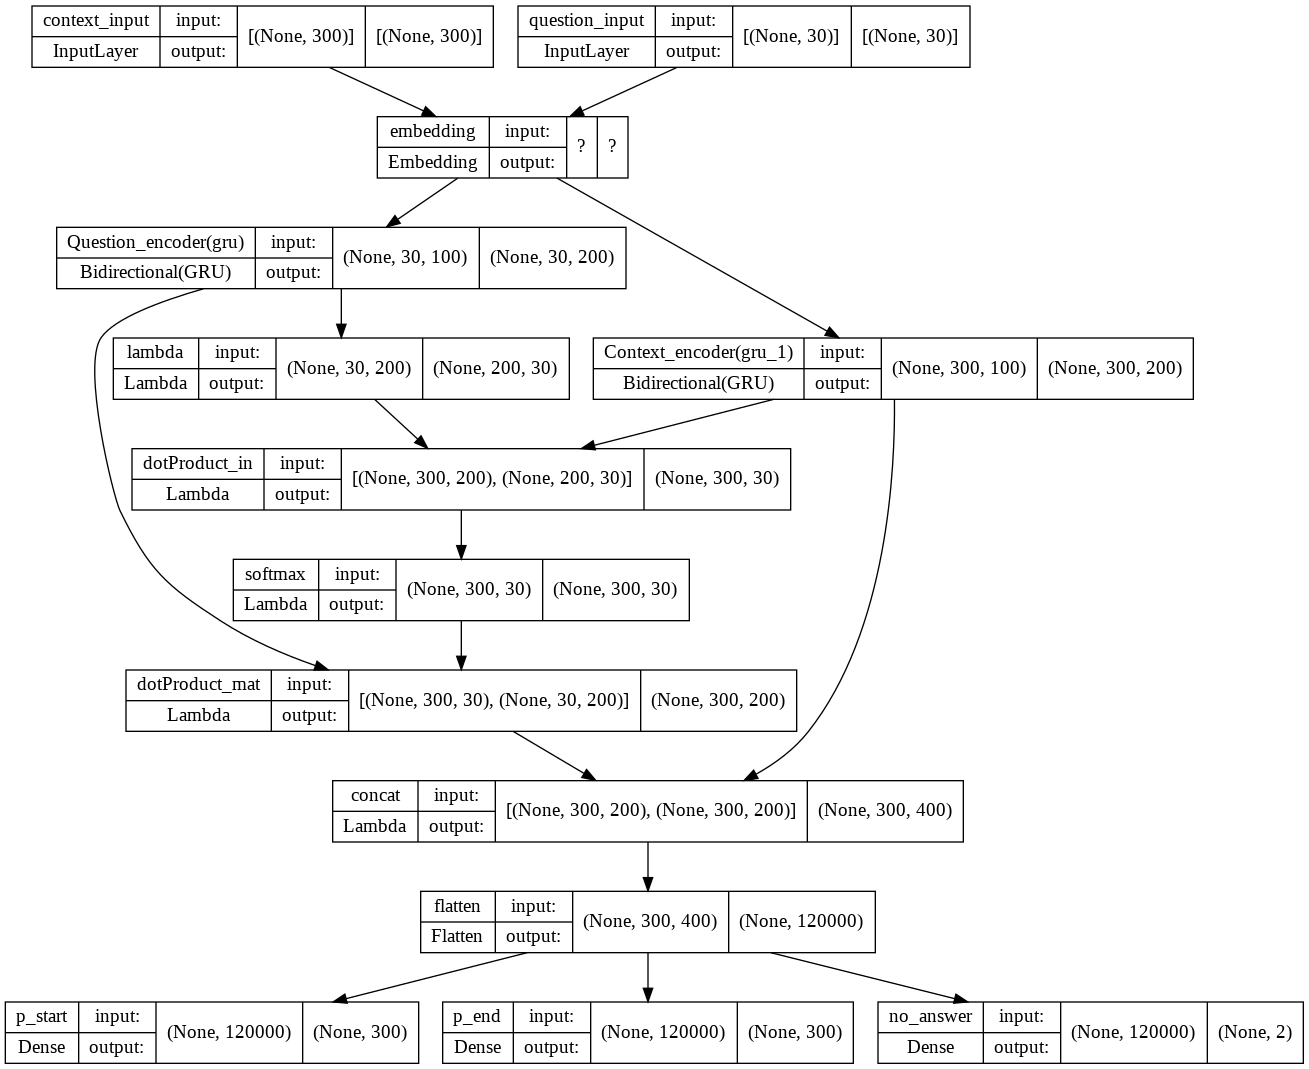

In [ ]:
import tensorflow as tf
tf.keras.utils.plot_model(model,show_shapes=True)

In [ ]:
import pickle
import numpy as np
from keras.callbacks import ModelCheckpoint

checkpoint_dir = 'drive/MyDrive/w266/GRU/Model_newloss/'
checkpoint_filepath = checkpoint_dir + 'weights.{epoch:02d}-{loss:.4f}.hdf5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True)


contexts = np.array([c[0] for c in preprocessed_train_data]).reshape(-1, CONTEXT_LEN)
questions = np.array([q[1] for q in preprocessed_train_data]).reshape(-1, QUESTION_LEN)
target_start = np.array([x[3] for x in preprocessed_train_data]).reshape(-1, CONTEXT_LEN)
target_end = np.array([x[4] for x in preprocessed_train_data]).reshape(-1, CONTEXT_LEN)
is_no_ans = np.array([x[5] for x in preprocessed_train_data]).reshape(-1, 2)
# model.fit([questions, contexts], [target_start, target_end, is_no_ans], epochs=1,
#           validation_split=0.05, callbacks=model_checkpoint_callback, batch_size=16, verbose=1)
# model.save('drive/MyDrive/w266/GRU/Model_newloss/gru_baseline.hdf5')


In [ ]:
# model.save('drive/MyDrive/w266/GRU/Model_newloss/gru_baseline.hdf5')

### Post-processing

In [ ]:
# model.load_weights('drive/MyDrive/w266/GRU/Model_newloss/gru_baseline.hdf5')

In [ ]:
n_best_size=20

In [ ]:
with open('drive/MyDrive/w266/GRU/Model_10E/preprocessing.pkl', 'rb') as f:
    preprocessing = pickle.load(f)

with open('drive/MyDrive/w266/GRU/Model_10E/test_data.pkl', 'rb') as f:
    test_data = pickle.load(f)

model = build_model(preprocessing.tokenizer,embedding_weights)
model.load_weights('drive/MyDrive/w266/GRU/Model_10E/weights.01-41.3618.hdf5')

preprocessed_test_data = list()
# for sample in test_data:
for i in range(len(test_data)):
  sample = test_data.iloc[i]
  # if sample[3] < sample[4] < CONTEXT_LEN or sample[3] == -1:
  preprocessed_test_data.append(preprocessing.text_to_seq_sample(sample))

result={}
i=0

for sample in preprocessed_test_data:
  id_ = str(sample[6])
  pred = model.predict([sample[1].reshape(1, QUESTION_LEN), sample[0].reshape(1, CONTEXT_LEN)])
  start_arr, end_arr, is_noans = pred
  is_noans = np.round(is_noans)
  start_indexes = np.argsort(start_arr.tolist()[0])[-1 : -n_best_size - 1 : -1].tolist()
  end_indexes = np.argsort(end_arr.tolist()[0])[-1 : -n_best_size - 1 : -1].tolist()

# problems
  # result[id_] = set()
  for j in range(n_best_size):
    if start_indexes[j] < end_indexes[j] and end_indexes[j]-start_indexes[j]< 30:
      p_start = start_indexes[j]
      p_end = end_indexes[j]
      result[id_]=preprocessing.target_to_words(sample[0].reshape(-1, ), p_start, p_end, is_noans)
    else: 
      result[id_]=''
    

  if (i + 1) % 500 == 0:
      print("{} samples done".format(i + 1))
  i += 1
  

In [ ]:
with open('gru_pred_results.json', 'w') as f:
  json.dump(result, f)

In [ ]:
!cp gru_pred_results.json drive/MyDrive/w266/GRU/Model_newloss/

In [ ]:
squad_v2=True
metric = load_metric("squad_v2")
if squad_v2:
    formatted_predictions = [{"id": k, "prediction_text": v, "no_answer_probability": 0.0} for k, v in result.items()]
else:
    formatted_predictions = [{"id": k, "prediction_text": v} for k, v in result.items()]
references = []
for i in range(len(test_data)):
  ex = test[i]
  references.append({"id": str(ex["id"]), "answers": ex["answers"]})
metric.compute(predictions=formatted_predictions, references=references)

{'HasAns_exact': 0.06535947712418301,
 'HasAns_f1': 2.0065458381199086,
 'HasAns_total': 10710,
 'NoAns_exact': 82.5305216426193,
 'NoAns_f1': 82.5305216426193,
 'NoAns_total': 4505,
 'best_exact': 29.608938547486034,
 'best_exact_thresh': 0.0,
 'best_f1': 29.617696927423033,
 'best_f1_thresh': 0.0,
 'exact': 24.482418665790338,
 'f1': 25.84884035006662,
 'total': 15215}

In [ ]:
pred = []
rfn = []
for i in range(len(formatted_predictions)):
  pd = formatted_predictions[i]
  ref = references[i]
  if pd['prediction_text'] != '':
    pred.append(pd)
    rfn.append(ref)

In [ ]:
metric.compute(predictions=pred, references=rfn)

{'HasAns_exact': 0.31446540880503143,
 'HasAns_f1': 11.21074734080934,
 'HasAns_total': 1908,
 'NoAns_exact': 0.2534854245880862,
 'NoAns_f1': 0.2534854245880862,
 'NoAns_total': 789,
 'best_exact': 29.254727474972192,
 'best_exact_thresh': 0.0,
 'best_f1': 29.304137467831513,
 'best_f1_thresh': 0.0,
 'exact': 0.29662588060808304,
 'f1': 8.005230228499896,
 'total': 2697}